1\. **Hurricanes per Year**

The number of hurricanes in 2005 was 15. The historic average is 6.3. Is this number signficantly different?
- Assume the number of hurricanes is random, i.e. follows the Poisson distribution.
- Assume as statistically significant a probability that has a Z score of 3 or larger with respect a normal distribution.

**Hint**: compute the probability that in a single year are observed 15 or more hurricances.

Z = 3.47


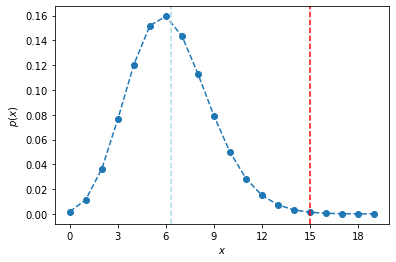

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

x0 = 15
mu = 6.3
sigma = np.sqrt(6.3)

# determine the Z score
Z = abs(x0 - mu) / sigma
print("Z =", '{:.2f}'.format(Z))

# plot the measurement and its assumed pdf
x = np.arange(0, 20, 1)
y = stats.poisson.pmf(x, mu)
plt.plot(x, y, marker='o', linestyle='dashed')
plt.axvline(mu, linestyle='--', color='lightblue')
plt.axvline(x0, linestyle='--', color='red')
plt.xticks(np.arange(0, 20, 3))
plt.ylabel("$p(x)$")
plt.xlabel("$x$")
plt.show()

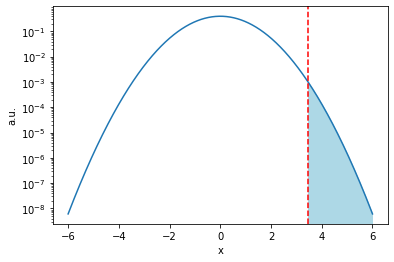

p-value = 0.0003


In [2]:
# plot the test statistics and its pdf
xs = np.linspace(-6, +6, 1000)
ts = stats.norm.pdf(xs)
plt.plot(xs, ts)
plt.fill_between(xs, ts, where=xs > Z, color='lightblue')
plt.axvline(Z, linestyle='--', color='red')
plt.ylabel("a.u.")
plt.xlabel("x")
plt.yscale("log")
plt.show()

# calculate the p-value
pvalue = 1. - stats.norm.cdf(Z)
print("p-value =", '{:.4f}'.format(pvalue))

Since the p-value is smaller then $\alpha = 0.05$, we conclude that observing 15 hurricances in a single year is signficantly different with respect to the historic average of 6.3.

2\. **Pairwise t-test**

In an experiment, a group of 10 individuals agreed to participate in a study of blood pressure changes following exposure to halogen lighting. Resting systolic blood pressure was recorded for each individual. The participants were then exposed to 20 minutes in a room lit only by halogen lamps. A post-exposure systolic blood pressure reading was recorded for each individual. The results are presented in the following data set:

```python
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
```

Determine whether the change in blood pressures within our sample was statistically significant.

**Hint:**
in this case, the Student's $t$-test should be performed to compare the two datasets.
Use the following test statistics:

$$T = \frac{\bar{x}_1 - \bar{x}_2}{\sigma \sqrt{\frac{2}{n}}}$$

and 

$$\sigma = \sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}$$

pre
mean: 116.7
sigma: 9.36

post
mean: 135.4
sigma: 12.50

T = 3.79


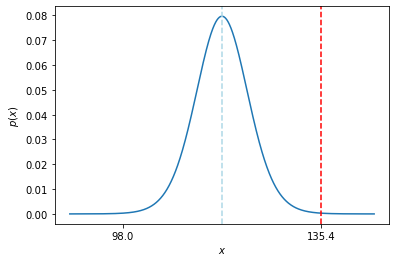

In [3]:
pre = np.array([120, 132, 120, 110, 115, 128, 120, 112, 110, 100])
mean_1 = np.mean(pre)
sigma_1 = np.sqrt(np.var(pre, ddof=1))
print('pre')
print('mean:', mean_1)
print('sigma:', '{:.2f}'.format(sigma_1))

post = np.array([140, 156, 145, 130, 117, 148, 137, 119, 127, 135])
mean_2 = np.mean(post)
sigma_2 = np.sqrt(np.var(post, ddof=1))
print('\npost')
print('mean:', mean_2)
print('sigma:', '{:.2f}'.format(sigma_2))

n = len(pre)
sigma = np.sqrt((sigma_2**2 + sigma_1**2)/2)
w = np.abs(mean_2 - mean_1)

# calculate the test statistics
T = (mean_2 - mean_1)/(sigma*np.sqrt(2/n))
print("\nT =", '{:.2f}'.format(T))

# plot the measurement and its assumed pdf
x = np.linspace(mean_1 - w - 10, mean_1 + w + 10, 1000)
y = stats.t.pdf(x, loc=mean_1, scale=sigma*np.sqrt(2/n), df=2*n - 2)
plt.plot(x, y)
plt.axvline(mean_1, linestyle='--', color='lightblue')
plt.axvline(mean_2, linestyle='--', color='red')
plt.xticks([mean_1 - w, mean_1 + w], [mean_1 - w, mean_1 + w])
plt.ylabel("$p(x)$")
plt.xlabel("$x$")
plt.show()

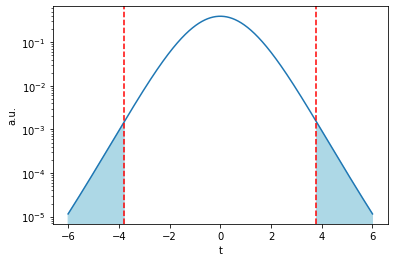

p-value = 0.0013


In [4]:
# plot the test statistics and its pdf
xs = np.linspace(-6, +6, 1000)
ts = stats.t.pdf(xs, 2*n - 2)
plt.plot(xs, ts)
plt.fill_between(xs, ts, where=np.abs(xs) > np.abs(T), color='lightblue')
plt.axvline(T, linestyle='--', color='red')
plt.axvline(-T, linestyle='--', color='red')
plt.ylabel("a.u.")
plt.xlabel("t")
plt.yscale("log")

plt.show()

# calculate the p-value
pvalue = stats.t.cdf(-T, 2*n - 2) + (1. - stats.t.cdf(T, 2*n - 2))
print("p-value =", '{:.4f}'.format(pvalue))

Since the p-value is smaller than $\alpha = 0.05$, we reject the null hypothesis (exposure to halogen lamps does not change resting systolic blood pressure) and therefore we conclude that the change in blood pressure in our sample was statistically significant. Nice article here: http://195.134.76.37/applets/AppletTtest/Appl_Ttest2.html

3\. **FFT of a simple dataset**

Perform a periodicity analysis on the lynxs-hares population, i.e. determine what is the period of the population of these animals.

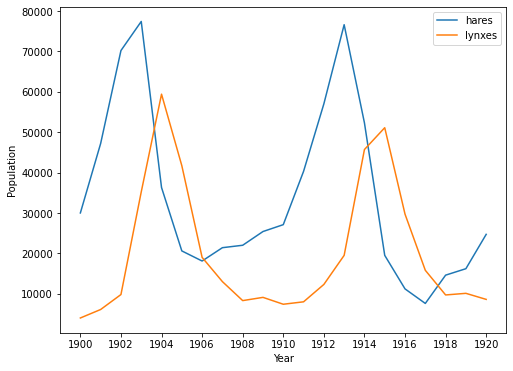

In [5]:
from scipy import fftpack

data = np.loadtxt("populations.txt")

years = data[:,0]
hares = data[:,1]
lynxes = data[:,2]

# plot
plt.figure(figsize=(8, 6))
plt.plot(years, hares, label = 'hares')
plt.plot(years, lynxes, label = 'lynxes')
plt.xticks(1900 + np.arange(0, 21, step=2))
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.show()

Peak frequency: 0.0952


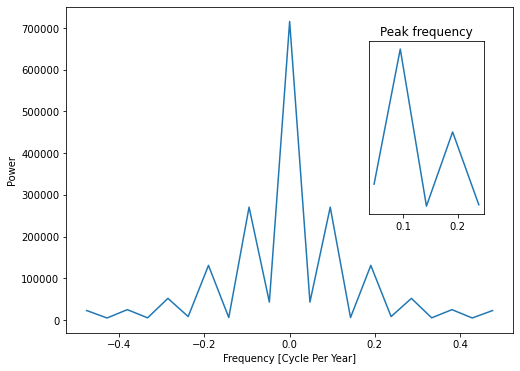

In [6]:
# HARES

# FFT of the signal
hares_fft = fftpack.fft(hares)
# FFT power
power = np.abs(hares_fft)
# corresponding frequencies
freq = fftpack.fftfreq(hares.size, d=1)

# plot the FFT power
plt.figure(figsize=(8, 6))
plt.plot(fftpack.fftshift(freq), fftpack.fftshift(power))
plt.xlabel('Frequency [Cycle Per Year]')
plt.ylabel('Power')

# find the peak frequency: focus only on the positive frequencies
pos_mask = np.where(freq > 0)
pos_freq = freq[pos_mask]
pos_power = power[pos_mask]
peak_freq = pos_freq[pos_power.argmax()]
print('Peak frequency:', '{:.4f}'.format(peak_freq))

# an inner plot to show the peak frequency
axes = plt.axes([0.65, 0.4, 0.2, 0.4])
axes.plot(pos_freq[:5], pos_power[:5])
axes.set_yticks([])
axes.set_title('Peak frequency')
plt.show()

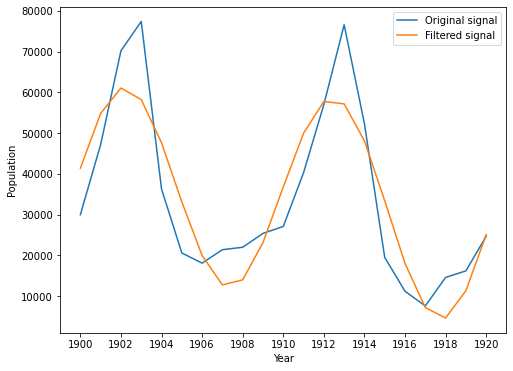

Period of the population of hares: 10.5 years


In [7]:
# filter (set to zero) all high frequency components that are larger than peak_freq
hares_fft2 = hares_fft.copy()
hares_fft2[np.abs(freq) > peak_freq] = 0
# calculate the Inverse FFT and take only the real part
filtered_hares = fftpack.ifft(hares_fft2).real

# plot the result of the IFFT
plt.figure(figsize=(8, 6))
plt.plot(years, hares, label='Original signal')
plt.plot(years, filtered_hares, label='Filtered signal')
plt.xticks(1900 + np.arange(0, 21, step=2))
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(loc='best')
plt.show()

print('Period of the population of hares:', 1/peak_freq, 'years')

Peak frequency: 0.0952


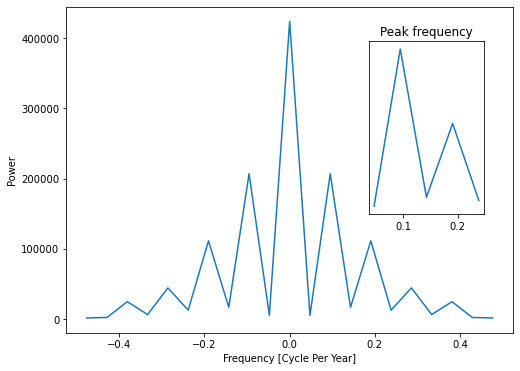

In [8]:
# LYNXES

# FFT of the signal
lynxes_fft = fftpack.fft(lynxes)
# FFT power
power = np.abs(lynxes_fft)
# corresponding frequencies
freq = fftpack.fftfreq(hares.size, d=1)

# plot the FFT power
plt.figure(figsize=(8, 6))
plt.plot(fftpack.fftshift(freq), fftpack.fftshift(power))
plt.xlabel('Frequency [Cycle Per Year]')
plt.ylabel('Power')

# find the peak frequency: focus only on the positive frequencies
pos_mask = np.where(freq > 0)
pos_freq = freq[pos_mask]
pos_power = power[pos_mask]
peak_freq = pos_freq[pos_power.argmax()]
print('Peak frequency:', '{:.4f}'.format(peak_freq))

# an inner plot to show the peak frequency
axes = plt.axes([0.65, 0.4, 0.2, 0.4])
axes.plot(pos_freq[:5], pos_power[:5])
axes.set_yticks([])
axes.set_title('Peak frequency')
plt.show()

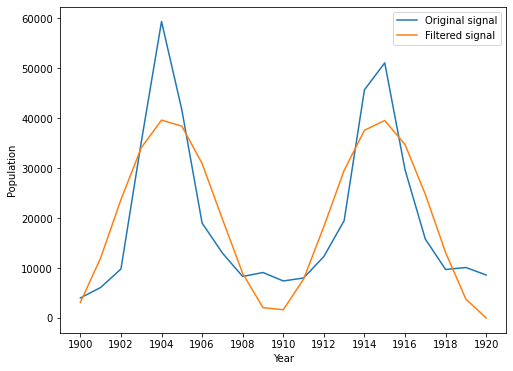

Period of the population of lynxes: 10.5 years


In [9]:
# filter (set to zero) all high frequency components that are larger than peak_freq
lynxes_fft2 = lynxes_fft.copy()
lynxes_fft2[np.abs(freq) > peak_freq] = 0
# calculate the Inverse FFT and take only the real part
filtered_lynxes = fftpack.ifft(lynxes_fft2).real

# plot the result of the IFFT
plt.figure(figsize=(8, 6))
plt.plot(years, lynxes, label='Original signal')
plt.plot(years, filtered_lynxes, label='Filtered signal')
plt.xticks(1900 + np.arange(0, 21, step=2))
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(loc='best')
plt.show()

print('Period of the population of lynxes:', 1/peak_freq, 'years')

4\. **FFT of an image**

Write a filter that removes the periodic noise from the `moonlanding.png` image by using a 2-dimensional FFT.

* Import the image as a 2D numpy array using `plt.imread("moonlanding.png")`. Examine the image with `plt.imshow()`, which is heavily contaminated with periodic noise.
* Check the documentation of the `scipy.fftpack` package, and find the method that performs a 2D FFT. Plot the spectrum (Fourier transform of) the image. **Hint**: use `LogNorm` to plot the colors in log scale:
```Python
from matplotlib.colors import LogNorm
plt.imshow(image, norm=LogNorm(vmin=5))
```
* Inspect the spectrum, and try to locate the regions of the power spectrum that contain the signal and those which contain the periodic noise. Use array slicing to set the noise regions to zero.
* Apply the inverse Fourier transform to plot the resulting image.

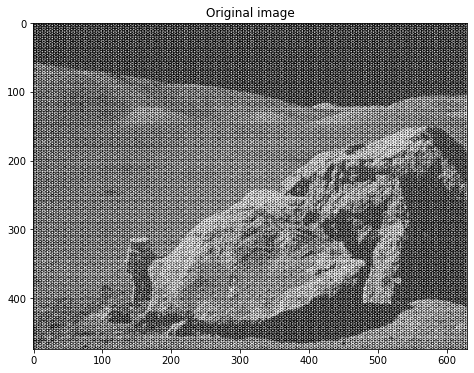

In [17]:
from matplotlib.colors import LogNorm

image = plt.imread('moonlanding.png')

plt.figure(figsize=(8, 6))
plt.imshow(image, plt.cm.gray)
plt.title('Original image')
plt.show()

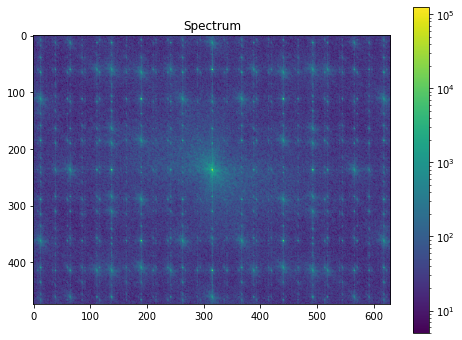

In [18]:
# FFT of the image
image_fft = fftpack.fftshift(fftpack.fft2(image))

plt.figure(figsize=(8, 6))
plt.imshow(np.abs(image_fft), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Spectrum')
plt.show()

We want to select only those regions of the power spectrum that contain the signal, i.e. we want to suppress the noise.

To do this, we first note that the low frequency components with high power values around the origin correspond to the smooth parts of the image, while the higher frequency components correspond to the details. Finally, the peaks around the higher frequencies represent the noise.

So the idea is to preserve the low frequency components and apply a filter on the higher frequency ones to suppress the peaks.

Note: Scipy's FFT function first plots the positive and then the negative frequencies (both in ascending order), so we will apply a shift to the spectrum.

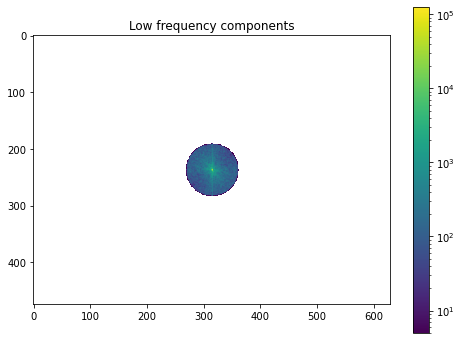

In [60]:
# Low Frequency components

# make a copy
image_fft_LF =  image_fft.copy()

# get the number of rows and columns
rows, columns = image_fft_LF.shape

# estimate the coordinates of the spectrum origin
rows_center = int(rows/2)
columns_center = int(columns/2)

# define the disk radius centered in the spectrum origin used to select only low frequency components
radius = 45

# select only low frequency components
for r in range(rows):
    for c in range(columns):
        d = np.sqrt((r - rows_center)**2 + (c - columns_center)**2)
        if d > radius:
            image_fft_LF[r,c] = 0            

plt.figure(figsize=(8, 6))
plt.imshow(np.abs(image_fft_LF), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Low frequency components')
plt.show()

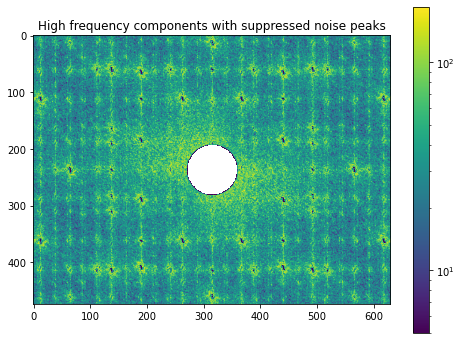

In [61]:
# High Frequency components

# make a copy
image_fft_HF =  image_fft.copy()

# select only high frequency components
image_fft_HF -= image_fft_LF

# define the threshold used to suppress noise peaks
threshold = 0.005*np.max(np.abs(image_fft_HF))

# suppress noise peaks
image_fft_HF[np.abs(image_fft_HF) > threshold] = 0

plt.figure(figsize=(8, 6))
plt.imshow(np.abs(image_fft_HF), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('High frequency components with suppressed noise peaks')
plt.show()

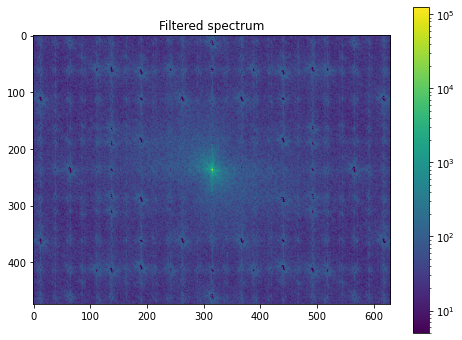

In [62]:
# recompose filtered spectrum
image_fft_filtered =  image_fft_LF + image_fft_HF

plt.figure(figsize=(8, 6))
plt.imshow(np.abs(image_fft_filtered), norm=LogNorm(vmin=5))
plt.colorbar()
plt.title('Filtered spectrum')
plt.show()

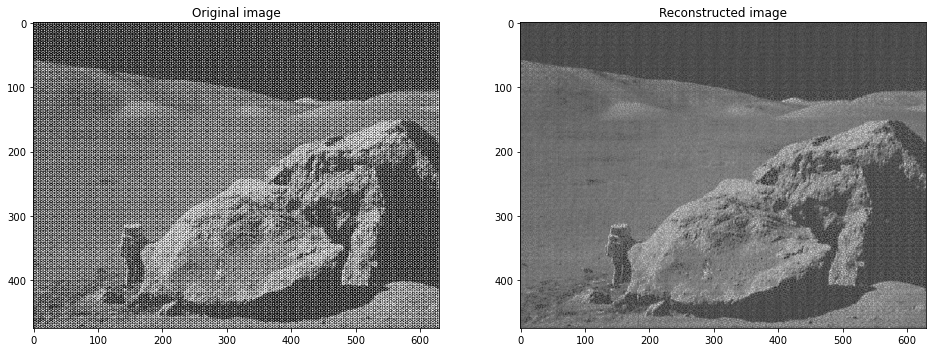

In [63]:
# reconstruct the image
image_fft_filtered = fftpack.fftshift(image_fft_filtered)
filtered_image = fftpack.ifft2(image_fft_filtered).real

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
ax[0].imshow(image, plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(filtered_image, plt.cm.gray)
ax[1].set_title('Reconstructed image')
plt.show()